In [1]:
# Install libraries and dependencies
!pip install nltk

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import torch
from torch import nn
import torch.optim as optim

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/Symptom2Disease.csv


In [3]:
# Load in dataset using pandas
df = pd.read_csv('/kaggle/input/Symptom2Disease.csv')
df = df.drop('Unnamed: 0', axis=1) # Removing first column, it gives us no real information it is just the row number
df.head()

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."


In [4]:
# Report basic statistics on the dataset

print("Number of rows:", len(df))

# Get vocab size before any preprocessing
vocabBeforePreprocessing = set()
for entry in df['text']:
    symptomDesc = entry.split()
    for word in symptomDesc:
        vocabBeforePreprocessing.add(word)
        
print("Vocab size before preprocessing:", len(vocabBeforePreprocessing))

# Get list of diagnosis labels and their distribution
labels = {}
for label in df['label']:
    labels[label] = labels.get(label, 0) + 1
print("Number of labels:", len(labels.keys()))
print("\nList of labels and their frequency:")
for key, value in labels.items():
    print(key, value)
print("\nNull Values in each row:")
print(df.isna().sum())

Number of rows: 1200
Vocab size before preprocessing: 2508
Number of labels: 24

List of labels and their frequency:
Psoriasis 50
Varicose Veins 50
Typhoid 50
Chicken pox 50
Impetigo 50
Dengue 50
Fungal infection 50
Common Cold 50
Pneumonia 50
Dimorphic Hemorrhoids 50
Arthritis 50
Acne 50
Bronchial Asthma 50
Hypertension 50
Migraine 50
Cervical spondylosis 50
Jaundice 50
Malaria 50
urinary tract infection 50
allergy 50
gastroesophageal reflux disease 50
drug reaction 50
peptic ulcer disease 50
diabetes 50

Null Values in each row:
label    0
text     0
dtype: int64


In [5]:
# Data preprocessing

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Convert labels to lowercase just so we are working with cleaner labels
df['label'] = df['label'].str.lower()

# Convert symptom descriptions to lowercase
df['text'] = df['text'].str.lower()

# Remove stop words such as "the", "and", "is", etc.
stopwordsSet = set(stopwords.words('english'))
print("Stopwords:", stopwordsSet)
def remove_stopwords(text): # Helper function to remove stopwords
    stop_words = stopwordsSet
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text
df['text'] = df['text'].apply(remove_stopwords)

# Apply stemming to the symptom descriptions
def apply_stemming(text):
    stemmer = SnowballStemmer("english")
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

df['text'] = df['text'].apply(apply_stemming)

# Remove commas, apostrophes, and periods
df['text'] = df['text'].str.replace(",", "")
df['text'] = df['text'].str.replace(".", "")
df['text'] = df['text'].str.replace("'", "")

# Now let's see how our vocab has changed
vocabAfterPreprocessing = set()
for entry in df['text']:
    symptomDesc = entry.split()
    for word in symptomDesc:
        vocabAfterPreprocessing.add(word)
print("\nVocab size after preprocessing:", len(vocabAfterPreprocessing))

df.head()

Stopwords: {'so', 'been', 'a', 'through', 'and', 'couldn', 'shouldn', 'when', 'weren', 'own', 'or', 'can', 'under', 'won', 'now', 'his', "you're", 'hers', "mightn't", 'him', 'me', 'below', 'i', 'o', 'was', 'll', 'other', 'what', 'ourselves', 'by', 'are', 'don', 'to', 'very', "you'd", 'is', 'any', 'but', 'at', 'themselves', 'have', 'while', 'such', "doesn't", 'myself', 'theirs', 'who', 'having', 'our', 'too', 're', "needn't", 'after', 'not', "hasn't", 'up', 'here', 'ours', 'her', "hadn't", 'does', 'this', 'for', "don't", 'them', 'didn', 'had', 'than', 'just', 'your', "that'll", 'because', 'd', 'yourselves', 'mightn', 'she', 'their', 'wasn', 'those', 'do', 'between', 'some', 'until', "wouldn't", "you've", 'mustn', 'it', 'where', 's', 'in', 'needn', 'he', 'only', 'both', 'an', "haven't", 'yourself', 'we', 'you', 'as', 'these', 'doesn', "shan't", 'against', 'into', 'isn', 'how', 'off', 'y', 'same', "won't", 'my', 'during', 'herself', 'itself', 'doing', 'hadn', "weren't", 'ma', 'that', "it'

,label,text
0,psoriasis,experienc skin rash arms legs torso past weeks...
1,psoriasis,skin peeling especi knees elbows scalp peel of...
2,psoriasis,experienc joint pain fingers wrists knees pain...
3,psoriasis,silver like dust skin especi lower back scalp ...
4,psoriasis,nail small dent pit them often feel inflammato...


In [6]:
# Functions to check accuracy on multiple label output

# Function to check if top k predictions mentions correct label
# Inclusion = 1 if the top predicted diagnoses contains the true diagnosis, 0 otherwise
def top_k_label_check(true_diagnosis, top_predicted_diagnoses, k):
    if true_diagnosis in top_predicted_diagnoses:
        inclusion = 1
    else:
        inclusion = 0
    return inclusion

# Original function used to evaluate the model's inclusion accuracy
# Inclusion accuracy: How much the model mentions the true label in its top k labels
def evaluate_inclusion_accuracy(label_prob_pairs, k):
    inclusion_sum = 0
    
    total_samples = len(label_prob_pairs)
    
    # Loop over all samples
    for i in range(len(label_prob_pairs)):
        true_diagnosis = y_test.iloc[i]
        top_predicted_diagnoses = [x[0] for x in label_prob_pairs[i]]
        inclusion_sum += top_k_label_check(true_diagnosis, top_predicted_diagnoses, k)
    
    # Get the accuracies and return them
    inclusion_accuracy = (inclusion_sum / total_samples)

    return inclusion_accuracy

# Attempt to improve the original inclusion accuracy function
def evaluate_inclusion_accuracy_improved(label_prob_pairs, k, test_labels):
    inclusion_sum = 0
    
    total_samples = len(label_prob_pairs)
    
    # Loop over all samples
    for i in range(len(label_prob_pairs)):
        true_diagnosis = test_labels.iloc[i]
        top_predicted_diagnoses = [x[0] for x in label_prob_pairs[i]]
        
        # Check if true diagnosis is in top k predicted diagnoses, and use its index to compute the weighted inclusion sum
        for idx, diagnosis in enumerate(top_predicted_diagnoses[:k]):
            if diagnosis == true_diagnosis:
                weight = 1 / (idx + 1) # Weight will be inversely proportional to the position the true label appeared in (so true appearing at 1 gets weight 1, appearing at 2 gets 1/2, etc)
                inclusion_sum += weight
                break
    
    # Get the accuracies and return them
    inclusion_accuracy = (inclusion_sum / total_samples)
    
    return inclusion_accuracy

In [7]:
# Train Multinomial Naive Bayes model with TF-IDF Vectorizer representation

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, train_size=0.8)

print(y_test)

# Do vectorization using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# Train the model
nb_model1 = MultinomialNB()
nb_model1.fit(X_train_tfidf, y_train)

1172                   diabetes
969                     allergy
439                   pneumonia
718                    migraine
1079              drug reaction
                 ...           
545                   arthritis
22                    psoriasis
946     urinary tract infection
996                     allergy
1169                   diabetes
Name: label, Length: 240, dtype: object


MultinomialNB()

In [8]:
# Test Multinomial Naive Bayes model with TF-IDF Vectorizer representation
    
# Get top probabilities, this returns a 2D array, where each row is a sample, and each column is the
# corresponding probability for each class
predicted_probabilities = nb_model1.predict_proba(X_test_tfidf)
# Convert predicted probabilities into label prob pairs, this is a 2D array, where each row is a sample,
# and each column is the corresponding label/probability in the form (label, probability)
label_prob_pairs = [sorted(zip(nb_model1.classes_, prob), key=lambda x: x[1], reverse=True) for prob in predicted_probabilities]

# Evaluate correctness accuracy and inclusion accuracy
y_pred = nb_model1.predict(X_test_tfidf)
nb_model1correctness = accuracy_score(y_test, y_pred)
nb_model1_original_inclusion = evaluate_inclusion_accuracy(label_prob_pairs, 3)
nb_model1_improved_inclusion = evaluate_inclusion_accuracy_improved(label_prob_pairs, 3, y_test)
print("Correctness accuracy:", nb_model1correctness)
print("Original Inclusion accuracy:", nb_model1_original_inclusion)
print("Improved Inclusion accuracy:", nb_model1_improved_inclusion)

Correctness accuracy: 0.8958333333333334
Original Inclusion accuracy: 1.0
Improved Inclusion accuracy: 0.9319444444444446


In [9]:
# Look at some specific test examples using the Naive Bayes model with TF-IDF Vectorizer
example_idx = 10
example_text = X_test.iloc[example_idx]
real_label = y_test.iloc[example_idx]

# Get top probabilities
predicted_probabilities = nb_model1.predict_proba(X_test_tfidf[example_idx])
# Get the top labels for this sample
label_prob_pairs = [sorted(zip(nb_model1.classes_, prob), key=lambda x: x[1], reverse=True) for prob in predicted_probabilities]
label_prob_pairs = label_prob_pairs[0]
top_labels = label_prob_pairs[:3]
    
# Get final prediction
prediction = nb_model1.predict(X_test_tfidf[example_idx])[0]

print("Example Text:", example_text)
print("Real Label:", real_label)
print("Predicted Label:", prediction)
print("Top Labels:", top_labels)

Example Text: iv high temperature vomiting chills intens itching also headach perspir lot iv realli uncomfort late nausea muscl ache
Real Label: malaria
Predicted Label: malaria
Top Labels: [('malaria', 0.8655691595559192), ('jaundice', 0.03040947216680953), ('pneumonia', 0.010933275988545696)]


In [12]:
# Train Multinomial Naive Bayes model with Word2Vec representation

tokenized_text = df['text'].apply(lambda x: x.split()) # Get text column data as arrays of words rather than strings
tagged_documents = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(df['text'])]

# Create and train Doc2Vec model to get document embeddings
doc2vec = Doc2Vec(vector_size=100, min_count=2, epochs=40)
doc2vec.build_vocab(tagged_documents)
doc2vec.train(tagged_documents, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

# Get document embeddings
document_embeddings = [doc2vec.infer_vector(words) for words in tokenized_text]

# Normalize document embeddings to avoid negative values
scaler = MinMaxScaler()
document_embeddings = scaler.fit_transform(document_embeddings)


# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(document_embeddings, df['label'], test_size=0.2, train_size=0.8)

print(y_test)

# Train the model
nb_model2 = MultinomialNB()
nb_model2.fit(X_train, y_train)

324    fungal infection
209            impetigo
408           pneumonia
806            jaundice
401           pneumonia
             ...       
363         common cold
205            impetigo
658        hypertension
338    fungal infection
542           arthritis
Name: label, Length: 240, dtype: object


MultinomialNB()

In [13]:
# Check accuracy on multiple label output

# Get top probabilities, this returns a 2D array, where each row is a sample, and each column is the
# corresponding probability for each class
predicted_probabilities = nb_model2.predict_proba(X_test)
# Convert predicted probabilities into label prob pairs, this is a 2D array, where each row is a sample,
# and each column is the corresponding label/probability in the form (label, probability)
label_prob_pairs = [sorted(zip(nb_model2.classes_, prob), key=lambda x: x[1], reverse=True) for prob in predicted_probabilities]

y_pred = nb_model2.predict(X_test)
nb_model2correctness = accuracy_score(y_test, y_pred)
nb_model2_original_inclusion = evaluate_inclusion_accuracy(label_prob_pairs, 3)
nb_model2_improved_inclusion = evaluate_inclusion_accuracy_improved(label_prob_pairs, 3, y_test)
print("Correctness accuracy:", nb_model2correctness)
print("Original inclusion accuracy:", nb_model2_original_inclusion)
print("Improved inclusion accuracy:", nb_model2_improved_inclusion)

Correctness accuracy: 0.7125
Original inclusion accuracy: 1.0
Improved inclusion accuracy: 0.7979166666666667


In [14]:
# Look at some specific test examples using the model (model using Word2Vec representation)
example_idx = 10
example_text = X_test[example_idx].reshape(1, -1) 
real_label = y_test.iloc[example_idx]

# Get top probabilities
predicted_probabilities = nb_model2.predict_proba(example_text)
label_prob_pairs = [sorted(zip(nb_model1.classes_, prob), key=lambda x: x[1], reverse=True) for prob in predicted_probabilities]
label_prob_pairs = label_prob_pairs[0]
top_labels = label_prob_pairs[:3]

# Get the original text data associated with the example
original_text = df.iloc[example_idx]['text']

# Get the final prediction for the selected example
prediction = nb_model2.predict(example_text)[0]

# Print the text, real label, and predicted label
print("Example Text:", original_text)
print("Real Label:", real_label)
print("Predicted Label:", prediction)
print("Top Labels", top_labels)

Example Text: experienc fatigu general feel malaise often feel tire lack energy even good night sleep
Real Label: pneumonia
Predicted Label: pneumonia
Top Labels [('pneumonia', 0.22847275380653778), ('gastroesophageal reflux disease', 0.0958068010328341), ('diabetes', 0.05822142739225977)]


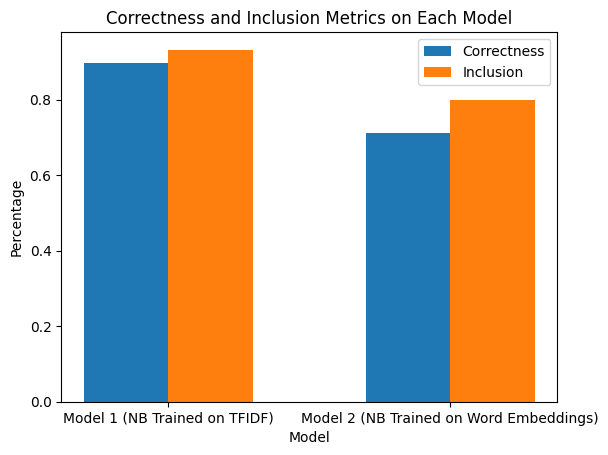

In [15]:
# Create graph to show difference between models

# Define the percentages
percentages = [(nb_model1correctness, nb_model1_improved_inclusion), (nb_model2correctness, nb_model2_improved_inclusion)]
models = ['Model 1 (NB Trained on TFIDF)', 'Model 2 (NB Trained on Word Embeddings)']
metrics = ['Correctness', 'Inclusion']

# Set the width of the bars
bar_width = 0.3

# Set the positions for the bars
x = np.arange(len(models))

# Plotting the percentages
fig, ax = plt.subplots()
for i in range(len(metrics)):
    ax.bar(x + i * bar_width, [percentages[j][i] for j in range(len(percentages))], bar_width, label=metrics[i])

# Adding labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Percentage')
ax.set_title('Correctness and Inclusion Metrics on Each Model')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.show()

In [16]:
# Begin attempts at neural network based approach

# Get best device to train model on
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        return out


Using cpu device


In [17]:
# Train neural network with TF-IDF representation

# First, handle getting the data as a TFIDF representation
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, train_size=0.8)

print(y_test)

# Initialize LabelEncoders for train and test data
label_encoder_train = LabelEncoder()
label_encoder_test = LabelEncoder()

# Fit LabelEncoders and encode data
label_encoder_train.fit(y_train)
label_encoder_test.fit(y_test)
y_train_encoded = label_encoder_train.transform(y_train)
y_test_encoded = label_encoder_test.transform(y_test)

# Convert labels to tensors
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Do vectorization using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert TF-IDF matrices to PyTorch tensors
X_train_tfidf = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tfidf = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
    
# Neural network parameters
input_size = X_train_tfidf.shape[1]
hidden_size = 100
num_classes = len(np.unique(df['label']))

# Create model, loss function, and optimizer
nn_nb_model1 = NeuralNetwork(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_nb_model1.parameters(), lr=0.001)

# Show the model
print(nn_nb_model1)

# Train the model
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(X_train_tfidf), batch_size):
        inputs = X_train_tfidf[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]
        
        # Zero your gradients for this batch
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = nn_nb_model1(inputs)
        
        # Compute loss function and its gradients
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("Model Trained")

85               varicose veins
650                hypertension
757        cervical spondylosis
1145       peptic ulcer disease
262                      dengue
                 ...           
658                hypertension
922     urinary tract infection
1158                   diabetes
952                     allergy
1086              drug reaction
Name: label, Length: 240, dtype: object
NeuralNetwork(
  (linear1): Linear(in_features=1381, out_features=100, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=100, out_features=24, bias=True)
)
Epoch [1/10], Loss: 3.1541
Epoch [2/10], Loss: 3.0050
Epoch [3/10], Loss: 2.5145
Epoch [4/10], Loss: 1.6606
Epoch [5/10], Loss: 0.8780
Epoch [6/10], Loss: 0.4257
Epoch [7/10], Loss: 0.2307
Epoch [8/10], Loss: 0.1380
Epoch [9/10], Loss: 0.0888
Epoch [10/10], Loss: 0.0609
Model Trained


In [18]:
# Test the neural network trained on TF-IDF representation
outputs = nn_nb_model1(X_test_tfidf)
_, predicted = torch.max(outputs, 1)
nn_nb_model1_correctness_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
print(f'Correctness Accuracy: {nn_nb_model1_correctness_accuracy}')

# Get the top-k predicted labels and probabilities
probabilities = torch.softmax(outputs, dim=1)
topk_probs, topk_indices = torch.topk(probabilities, k=3)

# Convert indices to labels using label_encoder_test
topk_labels = [[label_encoder_test.classes_[idx.item()] for idx in indices] for indices in topk_indices]

# Combine labels and probabilities for each sample
label_prob_pairs = [[(label, prob.item()) for label, prob in zip(labels, probs)] for labels, probs in zip(topk_labels, topk_probs)]

# Evaluate inclusion accuracy
nn_nb_model1_inclusion_accuracy = evaluate_inclusion_accuracy_improved(label_prob_pairs, 3, y_test)

print(f'Inclusion Accuracy: {nn_nb_model1_inclusion_accuracy}')

Correctness Accuracy: 0.9708333333333333
Inclusion Accuracy: 0.9854166666666667


In [22]:
# Train neural network with word embedding representation
tagged_documents = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(df['text'])]

# Create and train Doc2Vec model to get document embeddings
doc2vec = Doc2Vec(vector_size=100, min_count=2, epochs=40)
doc2vec.build_vocab(tagged_documents)
doc2vec.train(tagged_documents, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

# Get document embeddings
document_embeddings = [doc2vec.infer_vector(words) for words in tokenized_text]

# Normalize document embeddings to avoid negative values
scaler = MinMaxScaler()
document_embeddings = scaler.fit_transform(document_embeddings)

# Convert df['label'] to a numpy array
labels_array = df['label'].to_numpy()

# Use LabelEncoder to convert string labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_array)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(document_embeddings, labels_encoded, test_size=0.2, train_size=0.8)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test)

# Neural network parameters
input_size = X_train_tensor.shape[1]
hidden_size = 100  # You can adjust this
num_classes = len(np.unique(df['label']))

# Create model, loss function, and optimizer
nn_nb_model2 = NeuralNetwork(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_nb_model2.parameters(), lr=0.001)

# Show the model
print(nn_nb_model2)

# Train the model
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = nn_nb_model2(inputs)
        
        # Compute loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Model Trained")

NeuralNetwork(
  (linear1): Linear(in_features=100, out_features=100, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=100, out_features=24, bias=True)
)
Epoch [1/10], Loss: 3.1323
Epoch [2/10], Loss: 3.0477
Epoch [3/10], Loss: 2.8916
Epoch [4/10], Loss: 2.6586
Epoch [5/10], Loss: 2.3657
Epoch [6/10], Loss: 2.1341
Epoch [7/10], Loss: 1.9749
Epoch [8/10], Loss: 1.8575
Epoch [9/10], Loss: 1.7562
Epoch [10/10], Loss: 1.6683
Model Trained


In [23]:
# Test the neural network trained on word embedding representation
outputs = nn_nb_model2(X_test_tensor)
_, predicted = torch.max(outputs, 1)
nn_nb_model2_correctness_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
print(f'Correctness Accuracy: {nn_nb_model2_correctness_accuracy}')

# Get the top-k predicted labels and probabilities
probabilities = torch.softmax(outputs, dim=1)
topk_probs, topk_indices = torch.topk(probabilities, k=3)

# Convert indices to labels using label_encoder_test
topk_labels = [[label_encoder_test.classes_[idx.item()] for idx in indices] for indices in topk_indices]

# Combine labels and probabilities for each sample
label_prob_pairs = [[(label, prob.item()) for label, prob in zip(labels, probs)] for labels, probs in zip(topk_labels, topk_probs)]

# Evaluate inclusion accuracy
# Inverse numeric labels to get their original strings
y_test_labels = label_encoder.inverse_transform(y_test)
# Convert the labels back to a DataFrame
y_test_df = pd.DataFrame(y_test_labels, columns=['label'])
nn_nb_model2_inclusion_accuracy = evaluate_inclusion_accuracy_improved(label_prob_pairs, 3, y_test_df['label'])

print(f'Inclusion Accuracy: {nn_nb_model2_inclusion_accuracy}')

Correctness Accuracy: 0.5291666666666667
Inclusion Accuracy: 0.6430555555555555


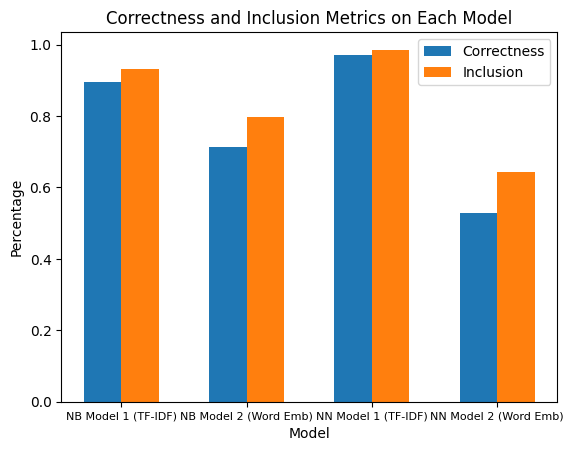

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define the percentages
percentages = [
    (nb_model1correctness, nb_model1_improved_inclusion),
    (nb_model2correctness, nb_model2_improved_inclusion),
    (nn_nb_model1_correctness_accuracy, nn_nb_model1_inclusion_accuracy),
    (nn_nb_model2_correctness_accuracy, nn_nb_model2_inclusion_accuracy)
]

models = [
    'NB Model 1 (TF-IDF)', 
    'NB Model 2 (Word Emb)',
    'NN Model 1 (TF-IDF)',
    'NN Model 2 (Word Emb)'
]

metrics = ['Correctness', 'Inclusion']

# Set the width of the bars
bar_width = 0.3

# Set the positions for the bars
x = np.arange(len(models))

# Plotting the percentages
fig, ax = plt.subplots()
for i in range(len(metrics)):
    ax.bar(x + i * bar_width, [percentages[j][i] for j in range(len(percentages))], bar_width, label=metrics[i])

# Adding labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Percentage')
ax.set_title('Correctness and Inclusion Metrics on Each Model')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(models, fontsize=8)
ax.legend()

# Display the plot
plt.show()

In [25]:
# Our best model was the first Neural Network trained on the TF-IDF representation, so we will use that model outside of this notebook
import pickle

with open("nn-tfidf-model.pkl", mode='wb') as model_file:
    pickle.dump(nn_nb_model1, model_file)